In [1]:
import pandas as pd 
import cplex 
from scipy.spatial.distance import cityblock

### Functions and Classes 

In [2]:
class location:
    def __init__(self,id,index,demand):
        self.id = id
        self.index = index
        self.demand = demand
        self.distance = {} # dict to save the distance to other locations
        
    def __str__(self):
        return str(self.id)
        return self.distance
        return self.demand

In [3]:
def create_graph(coordinates,demands):
    
    new_coordinates = coordinates.append(coordinates.iloc[0,:], ignore_index=True)
    new_demands = demands.append(demands.iloc[0,:], ignore_index=True)
    
    global C , N ,location_list
    
    N = len(new_coordinates)
    C = N - 1
    location_list = []
    
    #creation of locations
    for i in range(N):
        location_list.append(location(id='location_'+ str(i), index = i, demand = int(new_demands.iloc[i,0])))
        
    #create distances C_ij
    for i in location_list:
        for j in location_list:
            i.distance[j.index] = float(cityblock([int(new_coordinates.iloc[i.index,0]), int(new_coordinates.iloc[i.index,1])],[int(new_coordinates.iloc[j.index,0]),int(new_coordinates.iloc[j.index,1])]))

In [4]:
coordinates = pd.read_excel("CVRP_input.xlsx", sheet_name="locations",index_col=0)
demands = pd.read_excel("CVRP_input.xlsx", sheet_name="demands", index_col=0)

### Parameters 

In [5]:
Q = 15
K = 4
create_graph(coordinates,demands)

C:\Users\KEVIN\AppData\Local\Temp\ipykernel_11840\2730507921.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_coordinates = coordinates.append(coordinates.iloc[0,:], ignore_index=True)
C:\Users\KEVIN\AppData\Local\Temp\ipykernel_11840\2730507921.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_demands = demands.append(demands.iloc[0,:], ignore_index=True)


### Objective Function 

In [6]:
cpx = cplex.Cplex()
cpx.parameters.timelimit.set(225.0)
cpx.objective.set_sense(cpx.objective.sense.minimize)

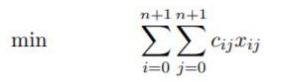

### Decision Variables 

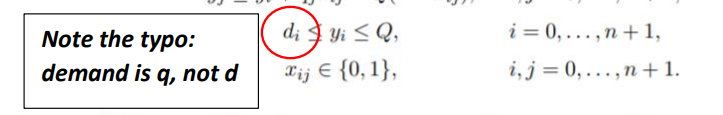

In [7]:
x = { i : { j : "x_"+str(i)+"_"+str(j) for j in range(N)} for i in range(N)}
y = { i : "y_" + str(i) for i in range(N)}    

In [8]:
# First add the decision variables that are in the objective function
for i in location_list:
    for j in location_list:
        cpx.variables.add(obj=[i.distance[j.index]], types=["B"], names=[x[i.index][j.index]])

In [9]:
for i in location_list:
    cpx.variables.add(lb=[i.demand], ub=[Q], types=["C"], names=[y[i.index]])

In [10]:
print(C,N)

41 42


In [11]:
print(location_list[17])

location_17


### Constraints 

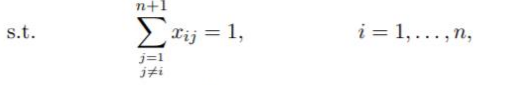

In [12]:
for i in location_list:
    if i.index != 0 and i.index != N-1: #i = 1,...,n #we use N-1 cause at the moment to create the locations the index took the iterable so the last element have the index=17 not N=18 and w 
        coef_1, var_1=[], []
        for j in location_list:
            if j.index != i.index and j.index != 0: # j =1 , j != i , j = n+1
                coef_1.append(1)
                var_1.append(x[i.index][j.index])
        cpx.linear_constraints.add(lin_expr=[[var_1,coef_1]], senses=["E"], rhs=[1])

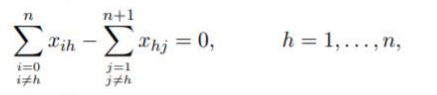

In [13]:
for h in location_list:
    if h.index != 0 and h.index != N-1 :
        coef_2, var_2 = [], []
        for i in location_list:
            if i.index != N-1 and i.index != h.index:
                coef_2.append(1)
                var_2.append(x[i.index][h.index])
        for j in location_list:
            if j.index != 0 and j.index != h.index:
                coef_2.append(-1)
                var_2.append(x[h.index][j.index])
        cpx.linear_constraints.add(lin_expr=[[var_2, coef_2]], senses=["E"], rhs=[0])

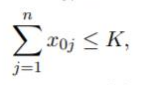

In [14]:
coef_3, var_3 = [], [] # constraints 3 (2.4)
for j in location_list:
    if j.index != 0 and j.index != N-1 :
        coef_3.append(1)
        var_3.append(x[0][j.index])
cpx.linear_constraints.add(lin_expr=[[var_3, coef_3]],senses=["L"],rhs=[K])

range(80, 81)

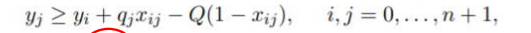


In [15]:
for i in location_list: 
    for j in location_list:
        if j.index != i.index:
            coef_4 = [1, -1, -j.demand - Q]
            var_4 = [y[j.index], y[i.index], x[i.index][j.index]]
            cpx.linear_constraints.add(lin_expr=[[var_4, coef_4]], senses=["G"], rhs=[-Q])

In [16]:
for i in location_list: 
    for j in location_list:
        if j.index == i.index:
            coef_5 = [-j.demand - Q]
            var_5 = [x[i.index][j.index]]
            cpx.linear_constraints.add(lin_expr=[[var_5, coef_5]], senses=["G"], rhs=[-Q])

In [17]:
cpx.solve()
print()
print("Solution status = ", cpx.solution.get_status(), ":", end=' ')
print(cpx.solution.status[cpx.solution.get_status()])
print("Solution value  = ", cpx.solution.get_objective_value())
print()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               225
Tried aggregator 1 time.
MIP Presolve eliminated 224 rows and 146 columns.
MIP Presolve modified 4660 coefficients.
Reduced MIP has 1621 rows, 1660 columns, and 7820 nonzeros.
Reduced MIP has 1620 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (6.32 ticks)
Probing time = 0.02 sec. (3.25 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1621 rows, 1660 columns, and 7820 nonzeros.
Reduced MIP has 1620 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (5.19 ticks)
Probing time = 0.02 sec. (3.16 ticks)
Clique table members: 4124.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.02 sec. (3.45 ticks)

        Nodes                              

  13892     0     6816.3160   118                   Cuts: 168   443153         
  13892     0     6820.1242   120                    Cuts: 88   443228         
  13892     0     6829.8004   112                    Cuts: 13   443298         
  13892     0     6833.2901   123                   Cuts: 119   443413         
  13892     0     6839.1550   122                    Cuts: 16   443458         
  13892     0     6841.8927   116                   Cuts: 115   443600         
  13892     0     6842.6068   123                   Cuts: 238   443697         
  13892     2     6842.6068   119                   6872.4603   443697         
  13941    38     7103.1561   111                   6880.1587   450767         
  14012    95     7015.9667   105                   6880.1587   457140         
  14147   226     7468.0923    92                   6880.1587   471405         
  14395   423     8262.2894    93                   6880.1587   486233         
  14732   620     7755.6325   102       


GUB cover cuts applied:  16
Clique cuts applied:  23
Cover cuts applied:  29
Implied bound cuts applied:  46
Flow cuts applied:  38
Mixed integer rounding cuts applied:  52
Zero-half cuts applied:  81
Multi commodity flow cuts applied:  2
Lift and project cuts applied:  65
Gomory fractional cuts applied:  7

Root node processing (before b&c):
  Real time             =    1.69 sec. (718.55 ticks)
Parallel b&c, 8 threads:
  Real time             =  223.36 sec. (116518.19 ticks)
  Sync time (average)   =   27.54 sec.
  Wait time (average)   =    0.10 sec.
                          ------------
Total (root+branch&cut) =  225.05 sec. (117236.74 ticks)


CPLEX Error  1217: No solution exists.



Solution status =  108 : MIP_time_limit_infeasible


CplexSolverError: CPLEX Error  1217: No solution exists.

In [ ]:
solution_x, solution_y=[], {}

for i in location_list:
    for j in location_list:
        if cpx.solution.get_values(x[i.index][j.index]) > 0:
            solution_x.append([x[i.index][j.index],i.index,j.index])
    
    solution_y[i.index]=round(cpx.solution.get_values(y[i.index]),0)